In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


**LOADING THE DATASET - Fashion MNIST**

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
noise_factor = 0.25
x_train_noisy = np.clip(x_train + noise_factor * np.random.randn(*x_train.shape), 0., 1.)
x_test_noisy = np.clip(x_test + noise_factor * np.random.randn(*x_test.shape), 0., 1.)


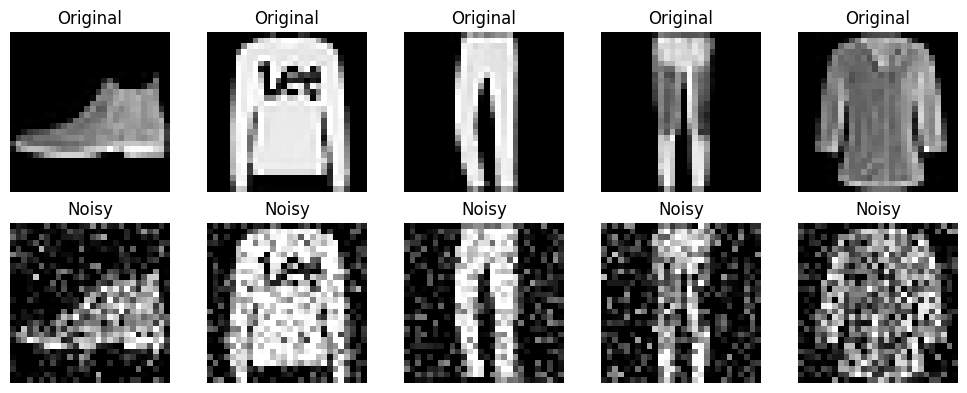

In [5]:
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i],cmap='gray')
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i],cmap='gray')
    plt.axis("off")
    plt.title("Noisy")

plt.tight_layout()
plt.show()


**BASELINE CONVOLUTIONAL AUTOENCODER:**

Encoder:
Uses Conv2D and MaxPooling2D layers to extract important patterns and reduce noise.

Decoder:Uses Conv2D and UpSampling2D layers to rebuild the image back to its original size.

Final Layer:Conv2D(1, (3,3), activation='sigmoid') outputs a grayscale image with pixel values between 0 and 1.

In [7]:
autoencoder = models.Sequential([
    # Encoder
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),

    # Decoder
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0467 - val_loss: 0.0163
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0149 - val_loss: 0.0137
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0096 - val_loss: 0.0096


In [9]:
decoded_imgs = autoencoder.predict(x_test_noisy)

psnr_scores = []
ssim_scores = []
for i in range(len(x_test)):
    psnr_scores.append(psnr(x_test[i].squeeze(), decoded_imgs[i].squeeze()))
    ssim_scores.append(ssim(x_test[i].squeeze(), decoded_imgs[i].squeeze(), data_range=1.0))

print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Average PSNR: 20.63 dB
Average SSIM: 0.7554


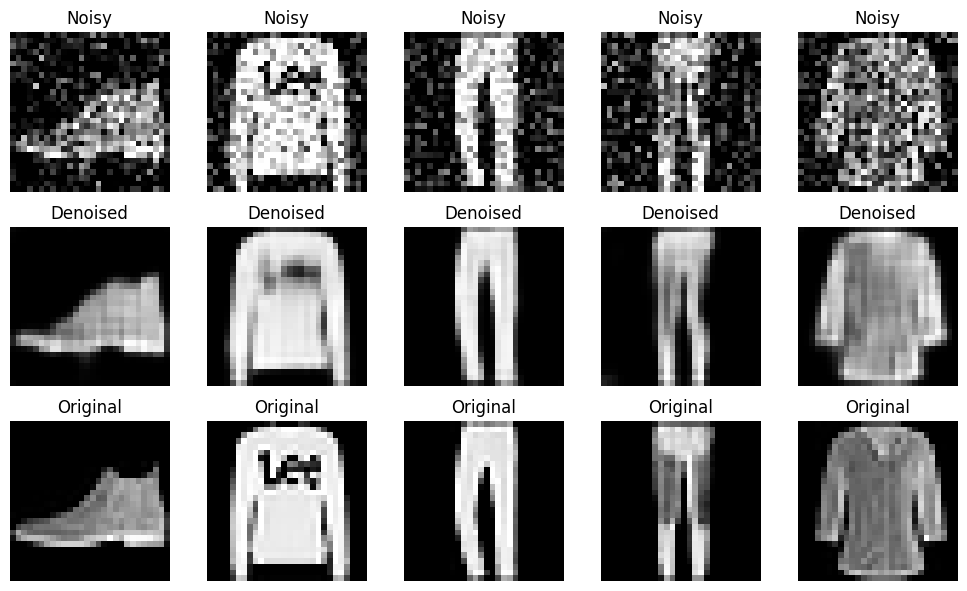

In [10]:
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()


**CONVOLUTIONAL AUTOENCODER WITH COMBINED LOSS FUNCTION(MSE+SSIM)**

This model uses the same Convolutional Autoencoder architecture as Model 1 but a different loss function to improve reconstruction quality.

The loss function combines:

*   Mean Squared Error (MSE): Measures pixel-wise difference between the clean
and denoised images.
*   Structural Similarity Index (SSIM): Measures visual similarity, focusing on structure, contrast, and brightness.


The combined loss is defined as :
𝛼
×
MSE
+
𝛽
×
(
1
−
SSIM
)


In [11]:
def combined_loss(alpha=0.8, beta=0.2):
    def loss(y_true, y_pred):
        mse = tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))
        ssim_val = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
        return alpha * mse + beta * (1.0 - ssim_val)
    return loss


In [12]:
autoencoder = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])
autoencoder.compile(optimizer='adam', loss=combined_loss(alpha=0.8, beta=0.2))


In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_st = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=15,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[reduce_lr, early_st]
)


Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0844 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0402 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0360 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0335 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0312 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0297 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0287 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0280 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 9/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0275 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 10/

In [14]:
decoded = autoencoder.predict(x_test_noisy)
psnrs = [psnr(x_test[i].squeeze(), decoded[i].squeeze(), data_range=1.0) for i in range(len(x_test))]
ssims = [ssim(x_test[i].squeeze(), decoded[i].squeeze(), data_range=1.0) for i in range(len(x_test))]
print("Average PSNR: {:.2f} dB".format(np.mean(psnrs)))
print("Average SSIM: {:.4f}".format(np.mean(ssims)))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average PSNR: 20.80 dB
Average SSIM: 0.7771


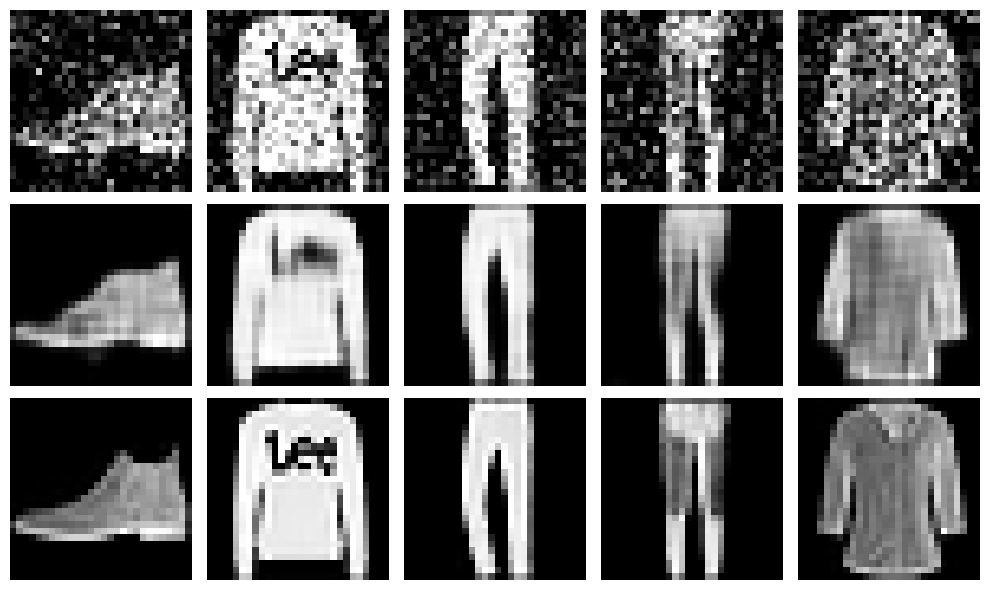

In [15]:
n = 5
plt.figure(figsize=(10,6))
for i in range(n):
    plt.subplot(3,n,i+1); plt.imshow(x_test_noisy[i].squeeze(), cmap='gray'); plt.axis('off')
    plt.subplot(3,n,i+1+n); plt.imshow(decoded[i].squeeze(), cmap='gray'); plt.axis('off')
    plt.subplot(3,n,i+1+2*n); plt.imshow(x_test[i].squeeze(), cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()


**DEEPER CONVOLUTIONAL AUTO-ENCODER**

In [17]:
autoencoder_deep = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),

    layers.UpSampling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),

    layers.UpSampling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

autoencoder_deep.compile(optimizer='adam', loss=combined_loss(alpha=0.8, beta=0.2))

In [18]:
history = autoencoder_deep.fit(
    x_train_noisy, x_train,
    epochs=15,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[reduce_lr, early_st]
)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 0.0660 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0246 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0222 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0209 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0202 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0194 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0190 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0187 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 9/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0185 - val_loss: 0.0189 - learning_rate:

In [19]:
decoded = autoencoder_deep.predict(x_test_noisy)

psnrs = [psnr(x_test[i].squeeze(), decoded[i].squeeze(), data_range=1.0) for i in range(len(x_test))]
ssims = [ssim(x_test[i].squeeze(), decoded[i].squeeze(), data_range=1.0) for i in range(len(x_test))]

print("Average PSNR: {:.2f} dB".format(np.mean(psnrs)))
print("Average SSIM: {:.4f}".format(np.mean(ssims)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Average PSNR: 22.70 dB
Average SSIM: 0.8371


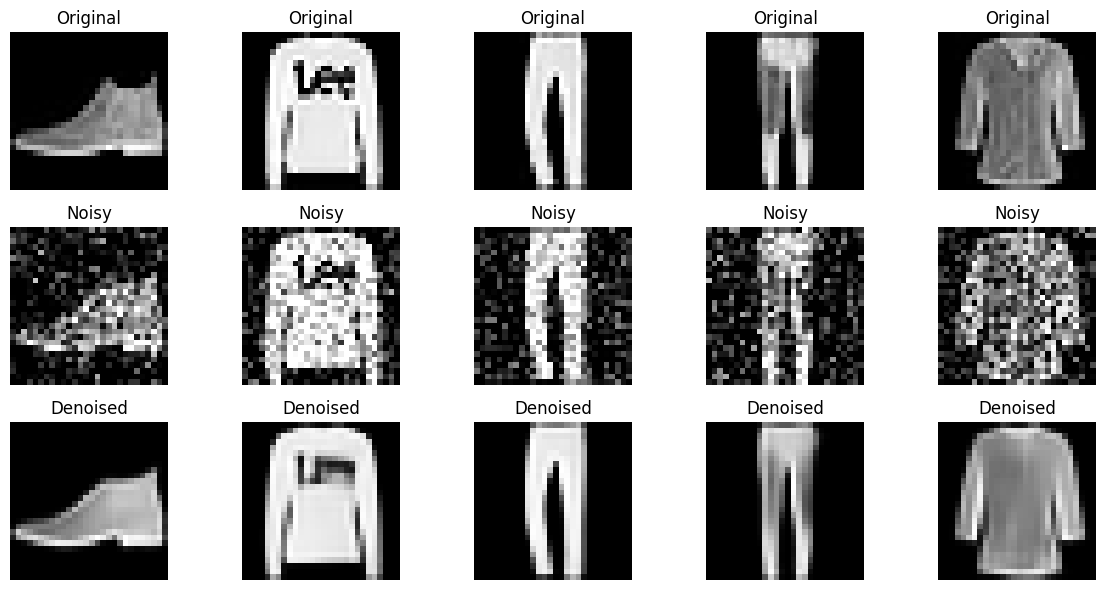

In [20]:
n = 5
plt.figure(figsize=(12, 6))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis("off")
    plt.title("Original")

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.axis("off")
    plt.title("Noisy")

    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded[i].squeeze(), cmap='gray')
    plt.axis("off")
    plt.title("Denoised")

plt.tight_layout()
plt.show()